# Step1. 검증용 데이터셋 준비

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
import cv2       
from tensorflow.keras import layers
from IPython import display
from pytesseract import Output
import matplotlib.pyplot as plt

In [48]:
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'
file_list = os.listdir(img_dir)
file_list.sort()
file_list

['1.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '13.jpg',
 '14.jpg',
 '15.jpg',
 '16.jpg',
 '17.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg']

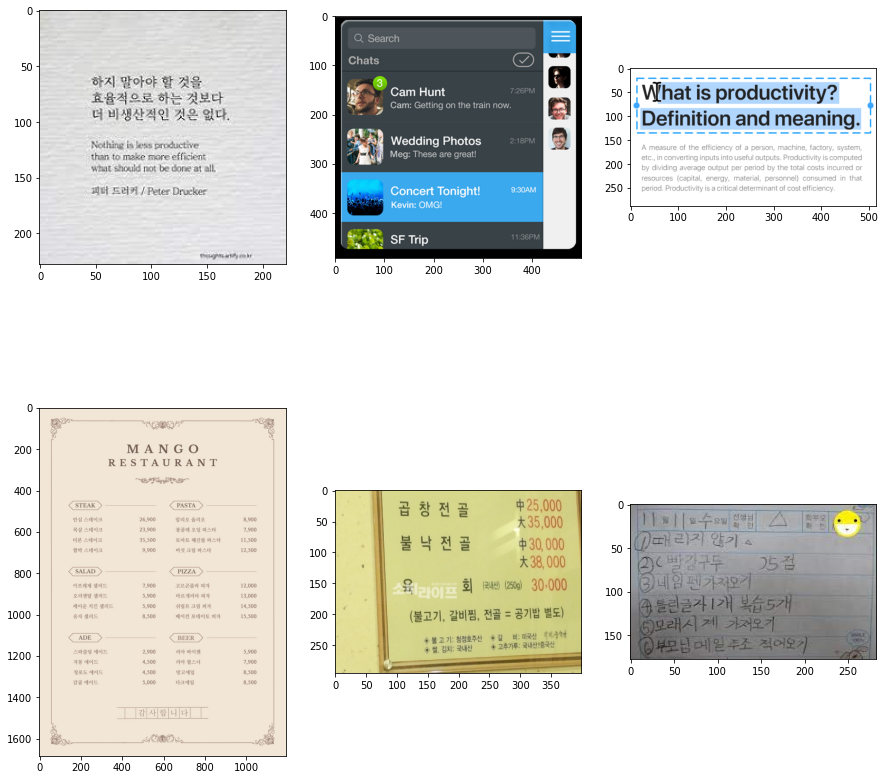

In [49]:
plt.figure(figsize=(15,15))
for i in range(6):
    plt.subplot(2, 3, i+1)
    img = cv2.imread(os.path.join(img_dir, file_list[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

# Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

## 1) Google OCR API

In [5]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [7]:
# # 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# # 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    path = os.path.join(img_dir, file)
    print(path)
    detect_text(path)

-rw-r--r-- 1 root root 2336 Sep 22 00:26 /aiffel/aiffel/ocr_python/my_google_api_key.json
/aiffel/aiffel/ocr_python/images/1.jpeg
Texts:

"하지 말아야 할 것을
효율적으로 하는 것보다
더 비생산적인 것은 없다.
Nothing is less productive
than to make more efficient
what should not be done at all.
H selA/ Peter Drucker
"

"하지"

"말아야"

"할"

"것을"

"효율적"

"으로"

"하는"

"것"

"보다"

"더"

"비생산적인"

"것은"

"없다"

"."

"Nothing"

"is"

"less"

"productive"

"than"

"to"

"make"

"more"

"efficient"

"what"

"should"

"not"

"be"

"done"

"at"

"all."

"H"

"selA/"

"Peter"

"Drucker"
bounds: (120,159),(149,159),(149,166),(120,166)
/aiffel/aiffel/ocr_python/images/10.png
Texts:

"Q Search
Chats
3
Cam Hunt
7:26PM
Cam: Getting on the train now.
Wedding Photos
2:18PM
Meg: These are great!
Concert Tonight!
9:30AM
Kevin: OMG!
11:36PM
SF Trip
II
"

"Q"

"Search"

"Chats"

"3"

"Cam"

"Hunt"

"7:26PM"

"Cam:"

"Getting"

"on"

"the"

"train"

"now."

"Wedding"

"Photos"

"2:18PM"

"Meg:"

"These"

"are"

"great!"

"Concert"

"Tonight!"

"9

## 2) keras-ocr

In [38]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [50]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

error: OpenCV(4.5.1) /tmp/pip-req-build-hj027r8z/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [51]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

NameError: name 'images' is not defined

## 3) Tesseract (테서렉트)

In [58]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 0 not upgraded.
Need to get 7,031 kB of archives.
After this operation, 22.0 MB of additional disk space will be used.
Do you want to continue? [Y/n] ^C
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  liblept5 libleptonica-dev libopenjp2-7 libtesseract4
The following NEW packages will be installed:
  liblept5 libleptonica-dev libopenjp2-7 libtesseract-dev libtesseract4
0 upgraded, 5 newly installed, 0 to remove and 0 not upgraded.
Need to get 4,991 kB of archives.
After this operation, 

In [55]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [52]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [53]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [59]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/cropped'

for file in file_list:
    path = os.path.join(img_dir, file)
    print(path)
    cropped_image_path_list = crop_word_regions(os.path.join(img_dir, file), work_dir)
    recognize_images(cropped_image_path_list)
    print("-"*79)

/aiffel/aiffel/ocr_python/images/1.jpg
/aiffel/aiffel/ocr_python/cropped/0000.png
/aiffel/aiffel/ocr_python/cropped/0001.png
/aiffel/aiffel/ocr_python/cropped/0002.png
/aiffel/aiffel/ocr_python/cropped/0003.png
/aiffel/aiffel/ocr_python/cropped/0004.png
/aiffel/aiffel/ocr_python/cropped/0005.png
/aiffel/aiffel/ocr_python/cropped/0006.png
/aiffel/aiffel/ocr_python/cropped/0007.png
/aiffel/aiffel/ocr_python/cropped/0008.png
/aiffel/aiffel/ocr_python/cropped/0009.png
/aiffel/aiffel/ocr_python/cropped/0010.png
/aiffel/aiffel/ocr_python/cropped/0011.png
/aiffel/aiffel/ocr_python/cropped/0012.png
/aiffel/aiffel/ocr_python/cropped/0013.png
/aiffel/aiffel/ocr_python/cropped/0014.png
/aiffel/aiffel/ocr_python/cropped/0015.png
/aiffel/aiffel/ocr_python/cropped/0016.png
/aiffel/aiffel/ocr_python/cropped/0017.png
/aiffel/aiffel/ocr_python/cropped/0018.png
/aiffel/aiffel/ocr_python/cropped/0019.png
/aiffel/aiffel/ocr_python/cropped/0020.png
/aiffel/aiffel/ocr_python/cropped/0021.png
/aiffel/aiffel/

In [60]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [61]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/cropped'

for file in file_list:
    path = os.path.join(img_dir, file)
    print(path)
    cropped_image_path_list = crop_word_regions(os.path.join(img_dir, file), work_dir)
    recognize_images(cropped_image_path_list)
    print("-"*79)

/aiffel/aiffel/ocr_python/images/1.jpg
/aiffel/aiffel/ocr_python/cropped/0000.png
/aiffel/aiffel/ocr_python/cropped/0001.png
/aiffel/aiffel/ocr_python/cropped/0002.png
/aiffel/aiffel/ocr_python/cropped/0003.png
/aiffel/aiffel/ocr_python/cropped/0004.png
/aiffel/aiffel/ocr_python/cropped/0005.png
/aiffel/aiffel/ocr_python/cropped/0006.png
/aiffel/aiffel/ocr_python/cropped/0007.png
/aiffel/aiffel/ocr_python/cropped/0008.png
/aiffel/aiffel/ocr_python/cropped/0009.png
/aiffel/aiffel/ocr_python/cropped/0010.png
/aiffel/aiffel/ocr_python/cropped/0011.png
/aiffel/aiffel/ocr_python/cropped/0012.png
/aiffel/aiffel/ocr_python/cropped/0013.png
/aiffel/aiffel/ocr_python/cropped/0014.png
/aiffel/aiffel/ocr_python/cropped/0015.png
/aiffel/aiffel/ocr_python/cropped/0016.png
/aiffel/aiffel/ocr_python/cropped/0017.png
/aiffel/aiffel/ocr_python/cropped/0018.png
/aiffel/aiffel/ocr_python/cropped/0019.png
/aiffel/aiffel/ocr_python/cropped/0020.png
/aiffel/aiffel/ocr_python/cropped/0021.png
/aiffel/aiffel/

# Step3. 테스트 결과 정리

In [62]:
def test_result(img_path, idx):
   
    print("-"*79)
    print("Google OCR")
    detect_text(img_path)
    print("-"*79)
    print("keras-ocr")
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print("-"*79)
    print("Tesseract")
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/cropped'
    cropped_image_path_list=crop_word_regions(img_path, work_dir)
    recognize_images(cropped_image_path_list)

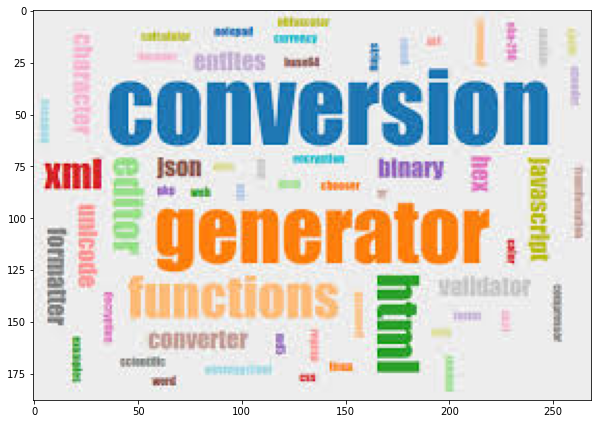

In [83]:
img_path = os.path.join(img_dir, file_list[13])
plt.figure(figsize=(10,10))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [84]:
test_result(img_path,0)

-------------------------------------------------------------------------------
Google OCR
Texts:

"tt
entites t
conversion
ernt
xml
Json
binary
theoser
generator.
functions
valldator
converter
cearmaar
Javascript
html
editor
onete
character
unicode
ales
formatter
"

"tt"

"entites"

"t"

"conversion"

"ernt"

"xml"

"Json"

"binary"

"theoser"

"generator."

"functions"

"valldator"

"converter"

"cearmaar"

"Javascript"

"html"

"editor"

"onete"

"character"

"unicode"

"ales"

"formatter"
bounds: (17,105),(16,151),(6,151),(7,105)
-------------------------------------------------------------------------------
keras-ocr


NameError: name 'images' is not defined

# 루브릭
1.OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?
- 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.

2.모델 평가기준이 명확하고 체계적으로 세워졌는가?
- 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.

3.평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?
- 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.

# 회고

한국어, 영어를 포함한 다양한 이미지를 테스트 이미지로 사용했다. google api로는 인식이 되던 이미지가 왜 keras-ocr에서는 비어있다고 뜨는지 모르겠다.